# Database Creation Notebook

Creation date: 12/09/2020

Created by: Lucas Rodrigues

Summary:

<ul>
<li>Problem Description and Objectives</li>
<li>Solution Description</li>
<li>Code and Comments</li>
<li>Limitations & What Could Be Done with Real Life Data</li>
<li>Conclusions and Improvements</li>
<li>References</li>
</ul>

## Problem Description and Objectives

In summary, the main question to be answered by the data in this demonstration is:
<blockquote>Can we determine the investor's profile based on the clients' daily expenses?</blockquote>

To answer this question, it is necessary to study the data regarding customer transactions. For this, a search and evaluation of bases of examples available on the internet was carried out. The bases analyzed were:


- Czech bank data:
    * https://www.researchgate.net/deref/http%3A%2F%2Fsorry.vse.cz%2F~berka%2Fchallenge%2Fpkdd1999%2Fdata_berka.zip
- Kaggle challenge's database: 
    * https://www.kaggle.com/c/santander-customer-transaction-prediction
    * https://www.kaggle.com/ntnu-testimon/paysim1
    * https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset
    * https://www.kaggle.com/apoorvwatsky/bank-transaction-data
- Others databases on Febraban and BACEN

Unfortunately, these databases are not suitable for the purpose of experiments. The main reasons were:

- No historical data of any transactions
- Not easy to indentify what could be a transactions
- Completely different from the format obtained by the Safra API
- Low data

So, to be feasible to create a model in Hackathon time, it was decided to create a base of transactions with fictitious data.

The main objective of this notebook is to create this foundation.


## Solution Description

The main objective is to create a database that, for a given customer, has a history of transactions. From this database, the modeling step will look for patterns to group different types of investment profiles.

With this objective, the solution adopted was a kind of reverse engineering, which the base follows this pattern in the data, with a certain amount of white noise. It is clear that in a real project, hypothesis testing and scientific methodology would be employed to validate this hypothesis. More details of the limitations and possible alternatives are discussed in the Limitations section and in the Presentation

Initially, it was discussed how the different profiles have their spending distributed in different spending ranges. To simplify the context, expense bands were created based on the Customer Credit Limit and Monthly Income (used as a basis for Debit type transactions). To distribute these profiles, a quick and non-exhaustive search was carried out (see References).

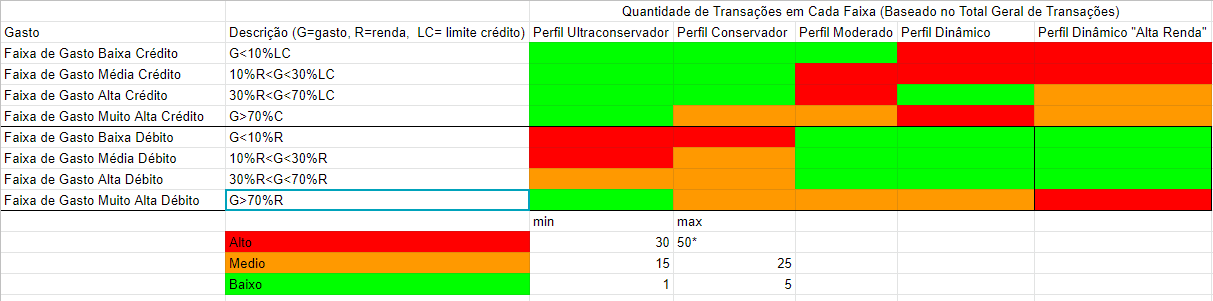

The solution, then, consists of two steps. First, an investment profile is given, generating spending ranges according to the table above. The second step consists of given an investment profile and a spending range table, to generate fictitious transactions. It is important to note that the value of each transaction is based on the percentage attributed to that range of expenditure. Total transactions do not necessarily generate a positive financial statement.

The results are stored in a Pandas Dataframe and exported as CSV for modeling. Additionally, a history of fictitious transactions was generated for the two clients registered in the Safra APIs, Suzan and Satya.

The remaining transaction data is generated from fictitious lists.

## Code and Comments

The first segment of the code is basically the setup of the Speding Range and Investment Profile

In [1]:
## Packages to use
import pandas as pd
import numpy as np
import random
import time

In [2]:
## List of Spending Ranges to use
lista_faixas = [
    'FaixadeGastoBaixaCredito',
    'FaixadeGastoMediaCredito',
    'FaixadeGastoAltaCredito',
    'FaixadeGastoMuitoAltaCredito',
    'FaixadeGastoBaixaDebito',
    'FaixadeGastoMediaDebito',
    'FaixadeGastoAltaDebito',
    'FaixadeGastoMuitoAltaDebito'
]
lista_faixas

In [3]:
## Create a pandas dataframe that contain information of how much each Spending Range is distributed
referencia = pd.DataFrame(data  = {
    'Faixas': lista_faixas,
    'PerfilUltraconservador': ['Baixo','Baixo','Baixo','Baixo','Alto','Alto','Medio','Baixo'],
    'PerfilConservador': ['Baixo','Baixo','Baixo','Medio','Alto','Medio','Medio','Medio'],
    'PerfilModerado': ['Baixo','Alto','Alto','Medio','Baixo','Baixo','Baixo','Medio'],
    'PerfilDinâmicoAltaRenda': ['Alto','Alto','Baixo','Alto','Baixo','Baixo','Baixo','Medio'],
    'PerfilDinâmico': ['Alto','Alto','Medio','Medio','Baixo','Baixo','Baixo','Alto'],
})
referencia

In [4]:
## Create a dict that contains the min and max of each range
dict_proporcao = {
    'Alto': {'Min': 0.3, 'Max': 0.5},
    'Medio': {'Min': 0.15, 'Max': 0.25},
    'Baixo': {'Min': 0.01, 'Max': 0.05},
}
print(dict_proporcao)
print(dict_proporcao['Alto'])

The second part of the code is based on created the Investment Perfil and Spending Range

In [5]:
def generate_random_value(acumulative = 0, prop = 'Baixo'):
    """
        Function to create random value to a given Spending Range, based on its max and min and return this 
        value plus the acumulative of all spending range made so far
        
        inputs:
        acumulative: float with total acumulated so far with spending Range
        prop: string of Spending Range proportion
        
        outputs:
        value: float value to a spending range
        acumulative: float with updated aculative (+ value)
        
        notes:
        to simplify this function made an direct acess to the dict defined above
    """
    if acumulative + dict_proporcao[prop]['Max'] < 1:
        value = random.uniform( dict_proporcao[prop]['Min'],  dict_proporcao[prop]['Max'])
    elif acumulative + dict_proporcao[prop]['Min'] < 1:
        value = random.uniform( 0, dict_proporcao[prop]['Min'])
    else:
        value = random.uniform( 0, 1-acumulative)
    return round(value,2), round(acumulative + value,2)

In [6]:
generate_random_value(acumulative = 0.8, prop = 'Alto')

(0.12, 0.92)

In [7]:
def generate_perfil(perfil = 'PerfilUltraconservador'):
    """
        Function to create random dataframe containing Spending Range to ginve profile
        
        inputs:
        perfil: float with total acumulated so far with spending Range
        
        outputs:
        new_perfil: pandas dataframe containing speding range
        
        notes:
        to simplify this function made an direct acess to the dict and dataframe defined above
    """
    new_perfil = pd.DataFrame()
    new_perfil['Faixas'] = referencia['Faixas']
    new_perfil['ProporcoesDeTransacoes'] = 0
    perfil_proportions = referencia[perfil]
    acumulative = 0
    for index, row in perfil_proportions.iteritems():
        value, acumulative = generate_random_value(acumulative = acumulative, prop = row)
        new_perfil['ProporcoesDeTransacoes'].loc[index] = value
    #print(new_perfil)
    if acumulative < 1:
        diff = 1 - acumulative
        #print('Diff: ', diff)
        for index, row in perfil_proportions.iteritems():
            if row == 'Alto':
                new_perfil['ProporcoesDeTransacoes'].loc[index] = new_perfil['ProporcoesDeTransacoes'].loc[index] + diff
                break
    #print('Acumulative: ', acumulative)
    #print('Total: ', new_perfil['ProporcoesDeTransacoes'].sum())
    return new_perfil

In [8]:
generate_perfil(perfil = 'PerfilDinâmicoAltaRenda')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Faixas,ProporcoesDeTransacoes
0,FaixadeGastoBaixaCredito,0.45
1,FaixadeGastoMediaCredito,0.39
2,FaixadeGastoAltaCredito,0.03
3,FaixadeGastoMuitoAltaCredito,0.02
4,FaixadeGastoBaixaDebito,0.03
5,FaixadeGastoMediaDebito,0.02
6,FaixadeGastoAltaDebito,0.04
7,FaixadeGastoMuitoAltaDebito,0.02


The third part of code is to create the transactions database.
Random settings for other transactions informations

In [9]:
dict_spend_limits = {
    'FaixadeGastoBaixaCredito': {'limit': 'C', 'Min': 0.001, 'Max': 0.1},
    'FaixadeGastoMediaCredito': {'limit': 'C', 'Min': 0.1, 'Max': 0.3},
    'FaixadeGastoAltaCredito': {'limit': 'C', 'Min': 0.3, 'Max': 0.7},
    'FaixadeGastoMuitoAltaCredito': {'limit': 'C', 'Min': 0.7, 'Max': 0.75},
    'FaixadeGastoBaixaDebito': {'limit': 'D', 'Min': 0.001, 'Max': 0.1},
    'FaixadeGastoMediaDebito': {'limit': 'D', 'Min': 0.1, 'Max': 0.3},
    'FaixadeGastoAltaDebito': {'limit': 'D', 'Min': 0.3, 'Max': 0.7},
    'FaixadeGastoMuitoAltaDebito': {'limit': 'D', 'Min': 0.7, 'Max': 0.75}
}
dict_spend_limits

{'FaixadeGastoBaixaCredito': {'limit': 'C', 'Min': 0.001, 'Max': 0.1},
 'FaixadeGastoMediaCredito': {'limit': 'C', 'Min': 0.1, 'Max': 0.3},
 'FaixadeGastoAltaCredito': {'limit': 'C', 'Min': 0.3, 'Max': 0.7},
 'FaixadeGastoMuitoAltaCredito': {'limit': 'C', 'Min': 0.7, 'Max': 0.75},
 'FaixadeGastoBaixaDebito': {'limit': 'D', 'Min': 0.001, 'Max': 0.1},
 'FaixadeGastoMediaDebito': {'limit': 'D', 'Min': 0.1, 'Max': 0.3},
 'FaixadeGastoAltaDebito': {'limit': 'D', 'Min': 0.3, 'Max': 0.7},
 'FaixadeGastoMuitoAltaDebito': {'limit': 'D', 'Min': 0.7, 'Max': 0.75}}

In [10]:
dict_limit_debit = {
    'PerfilUltraconservador' : {'Min' : 9400, 'Max': 1200000},
    'PerfilConservador': {'Min' : 9400, 'Max': 740000},
    'PerfilModerado': {'Min' : 14000, 'Max': 960000},
    'PerfilDinâmicoAltaRenda': {'Min' : 228000, 'Max': 48000000},
    'PerfilDinâmico': {'Min' : 9400, 'Max': 585000},
}
dict_limit_debit

{'PerfilUltraconservador': {'Min': 9400, 'Max': 1200000},
 'PerfilConservador': {'Min': 9400, 'Max': 740000},
 'PerfilModerado': {'Min': 14000, 'Max': 960000},
 'PerfilDinâmicoAltaRenda': {'Min': 228000, 'Max': 48000000},
 'PerfilDinâmico': {'Min': 9400, 'Max': 585000}}

In [11]:
dict_limit_credit = {
    'PerfilUltraconservador' : {'Min' : 9400, 'Max': 1200000},
    'PerfilConservador': {'Min' : 9400, 'Max': 740000},
    'PerfilModerado': {'Min' : 14000, 'Max': 960000},
    'PerfilDinâmicoAltaRenda': {'Min' : 228000, 'Max': 48000000},
    'PerfilDinâmico': {'Min' : 9400, 'Max': 585000},
}
dict_limit_credit

{'PerfilUltraconservador': {'Min': 9400, 'Max': 1200000},
 'PerfilConservador': {'Min': 9400, 'Max': 740000},
 'PerfilModerado': {'Min': 14000, 'Max': 960000},
 'PerfilDinâmicoAltaRenda': {'Min': 228000, 'Max': 48000000},
 'PerfilDinâmico': {'Min': 9400, 'Max': 585000}}

In [12]:
range_datas = [pd.Timestamp('2019-02-01'), pd.Timestamp('2020-03-01')]
range_datas = pd.date_range('2019-02-01','2020-03-01' , freq='H')
range_datas[1]

Timestamp('2019-02-01 01:00:00', freq='H')

In [13]:
tipo_transacao = ['Mensalidade Academia', 'Pagamento', 'Supermercado', 'Operadora de Telefone', 'Petshop', 'E-commerce', 'Farmacia', 
       'Serviços', 'Serviços de Streaming', 'Restaurante', 'Bar', 'Balada', 'Hospital', 'Aluguel', 'Transferencia', 'Curso',
       'Agencia de Viagem', 'Boleto', 'TED', 'DOC', 'Fatura']
tipo_transacao

['Mensalidade Academia',
 'Pagamento',
 'Supermercado',
 'Operadora de Telefone',
 'Petshop',
 'E-commerce',
 'Farmacia',
 'Serviços',
 'Serviços de Streaming',
 'Restaurante',
 'Bar',
 'Balada',
 'Hospital',
 'Aluguel',
 'Transferencia',
 'Curso',
 'Agencia de Viagem',
 'Boleto',
 'TED',
 'DOC',
 'Fatura']

Here we input an fake database with clients, made by a fake list of investors. This database contains client id and investment profile

In [18]:
clientes = pd.read_csv('data_perfil_investimento_agrupado.csv', sep = ',')
clientes.rename( columns={'Unnamed: 0':'id'}, inplace=True )
clientes = clientes[['id','perfil']]
clientes[0:10]

,id,perfil
0,818371,ultraconservador
1,125630,ultraconservador
2,830798,ultraconservador
3,673279,ultraconservador
4,823930,ultraconservador
5,851336,ultraconservador
6,291438,ultraconservador
7,637559,ultraconservador
8,147150,ultraconservador
9,372984,ultraconservador


In [19]:
clientes['perfil'].unique().tolist()

['ultraconservador', 'conservador', 'moderado', 'dinamico']

In [20]:
def create_random_transactions(new_perfil, credit, debit, total_transactions, client, perfil):
    """
        Function to create random transactions based on a Spending Range table, given profile
        
        inputs:
        new_perfil: pandas dataframe containing spending range
        credit: float containing limit of credit
        debit: float containing limit of debit (monthly income)
        total_transactions: intenger contaning total of transactions to be made
        client: string contaning client account
        perfil: string containing investment provile
        
        outputs:
        new_transaction: pandas dataframe containing historical with transactions
        
        notes:
        to simplify this function made an direct acess to the dict and dataframe defined above
    """
    new_transaction = pd.DataFrame()
    for index, row in new_perfil.iterrows():
        #print(row['Faixas'])
        transactions = int(row['ProporcoesDeTransacoes']*total_transactions)
        #print('total transactions faixa: ', transactions)
        if 'Credito' in row['Faixas']:
            limit = credit
            tipo = 'Credit'
        else:
            limit = debit
            tipo = 'Debit'
        for transaction in range(0,transactions):
            #print(transaction, transactions)
            v = random.uniform(dict_spend_limits[row['Faixas']]['Min'],dict_spend_limits[row['Faixas']]['Max'])
            value = round(v*limit,2)
            #print(value, v, row['Faixas'])
            data_row = {
                'amount' : value,
                'accountID': client,
                'transactionID': random.randint(10000,99999),
                'CreditDebitIndicator': tipo,
                'transactionInformation': random.choice(tipo_transacao),
                'valueDateTime': random.choice(range_datas),
                'Limite_Credito': credit,
                'Renda_Mensal': debit,
                'Perfil': perfil
            }
            #print(data_row)
            new_transaction = new_transaction.append(data_row, ignore_index = True)
    return new_transaction

In [22]:
def generate_random_salary(perfil):
    """
        function to random generate random limits to a given profile
    """
    credit_limit = random.uniform(dict_limit_credit[perfil]['Min'], dict_limit_credit[perfil]['Max'])
    debit_limit = random.uniform(dict_limit_debit[perfil]['Min'], dict_limit_debit[perfil]['Max'])
    return round(credit_limit,2), round(debit_limit,2)

In [23]:
generate_random_salary('PerfilUltraconservador')

(827227.6, 869233.31)

In [24]:
def transactions_Database():
    """
        Function to create random database transactions based on clients and profiles of clientes database
        
        inputs:
        none
        
        outputs:
        new_database: pandas dataframe containing historical with transactions to all clients
        
        notes:
        to simplify this function made an direct acess to the dict and dataframe defined above
    """
    new_database = pd.DataFrame()
    for index, row in clientes.iterrows():
        client_id = row['id']
        perfil_label = row['perfil']
        #['ultraconservador', 'conservador', 'moderado', 'dinamico']
        if row['perfil'] == 'ultraconservador':
            perfil = 'PerfilUltraconservador'
        elif row['perfil'] == 'conservador':
            perfil = 'PerfilConservador'
        elif row['perfil'] == 'moderado':
            perfil = 'PerfilModerado'
        elif row['perfil'] == 'dinamico':
            perfil = random.choice(['PerfilDinâmicoAltaRenda','PerfilDinâmico'])
        else:
            perfil = 'PerfilUltraconservador'
        credit_limit, debit_limit = generate_random_salary(perfil)
        new_perfil = generate_perfil(perfil = perfil)
        new_transactions = create_random_transactions(new_perfil = new_perfil, 
                                                      credit = credit_limit, 
                                                      debit = debit_limit, 
                                                      total_transactions = random.uniform(500,1000), 
                                                      client = client_id,
                                                      perfil = perfil_label)
        new_database = new_database.append(new_transactions, ignore_index = True)
    return new_database

In [25]:
t_inicio = time.time()
database = transactions_Database()
t_fim = time.time()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
print("Time elapsed: ", t_fim - t_inicio)

Time elapsed:  3865.632334947586


In [27]:
database.to_csv('transactions.csv')

The last part of the code is made to create a historical transactions to Safra API clients Susan and Satya

In [28]:
"""00711234511 -> Susan -> LC = 100 k -> conservadora
   00711234522 -> Satya -> LC = 150 K -> moderada
       
"""
new_database = pd.DataFrame()
new_perfil = generate_perfil(perfil = 'PerfilConservador')
new_transactions = create_random_transactions(new_perfil = new_perfil, 
                                                      credit = 100000, 
                                                      debit = 5000, 
                                                      total_transactions = random.uniform(500,1000), 
                                                      client = '00711234511',
                                                      perfil = 'conservador')
new_database = new_database.append(new_transactions, ignore_index = True)

In [29]:
new_perfil = generate_perfil(perfil = 'PerfilModerado')
new_transactions = create_random_transactions(new_perfil = new_perfil, 
                                                      credit = 150000, 
                                                      debit = 12500, 
                                                      total_transactions = random.uniform(500,1000), 
                                                      client = '00711234522',
                                                      perfil = 'moderado')
new_database = new_database.append(new_transactions, ignore_index = True)

In [30]:
new_database.to_csv('suzan_satya.csv')

## Limitations & What Could Be Done with Real Life Data

The creation of this database validates the hypothesis that the investment profiles behave differently when observing their daily spending ranges, as the data was generated in a way that the hypothesis proved to be correct. This hypothesis would be tested with real data and may or may not be validated.

If not validated, more studies could be conducted and new variables (characteristics) could be created and new hypotheses could be created and tested. For example: in addition to the spending range, could the type of spending (leisure, food, fuel, etc.) help to separate the types of investment profiles? Could the creation of statistical indexes (such as indexes to determine financial health, specific expenses, bank satisfaction, etc.) help in this distinction? How could other variables, besides expenses, such as sex, age, monthly income, available credit, financial education, etc., help to classify the profile?

These studies could be conducted with clients who have investments from the bank, analyzing their investment portfolio and from there obtaining the investment profile. Research could also be conducted to raise hypotheses.

It is important to note that even the refuted hypotheses bring validated knowledge to the business, ensuring more assertiveness in the decisions taken by the Bank.


## Conclusions and Improvements

Despite the simplifications adopted on this basis, an example database is extremely useful for the banking sector. Since security concerns and regulations limit access to data bank professionals.

An example database that simulates behavior well can also be used in data competitions, such as those made available via Kaggle and Hackathons, bringing ideas from outside into the organization.

At this point, the base could take advantage of other ways to generate fake data. Deep Learning techniques, such as generative adversarial network (GAN), can mirror real data, bringing more loyalty to the example base.

In addition to increasing fidelity to real-life data, the code can be improved to decrease the time required to generate a fictitious transaction. With current code, a base with around 700 thousand lines took approximately 1 hour and 10 minutes to generate. This increase in performance could be applied both by changing the strategy adopted to generate data (which in this code was concerned with following a hypothesis), as well as making operations here more efficient.

## References

This work was based on:

- https://www.anbima.com.br/pt_br/especial/raio-x-do-investidor-2020.htm
- de Almeida, Andre Luís Fernandes. "Estudo do mercado brasileiro de renda fixa e o perfil do investidor brasileiro." PhD diss., Universidade Federal do Rio de Janeiro, 2017. (available at http://monografias.poli.ufrj.br/monografias/monopoli10020143.pdf)
- Bandinelli, Michele Bettim. "Finanças comportamentais: orientação ao perfil do investidor pessoa física." (2010). (available at https://www.lume.ufrgs.br/handle/10183/29591)
- https://towardsdatascience.com/understanding-investment-risk-3882c58e00e0